In [1]:
using CairoMakie
using NLsolve
using CSV
using DataFrames

In [3]:
# Load the CSV file
data = CSV.read("From_Table_2.csv", DataFrame)

Row,Evaluator,gamma,ee_l_a,ee_u_a,ee_l_b,ee_u_b
,String31,Int64,Float64,Float64,Float64,Float64
1,Horowitz and Manski,0,5.4431,10.7493,6.1253,11.9906
2,Lee,0,7.9156,7.9156,7.5262,8.6729
3,Chen and Flores,0,7.9156,7.9156,8.3317,8.6729
4,Horowitz and Manski,2,4.0683,9.0403,3.7566,8.564
5,Lee,2,6.5767,6.5767,6.4984,7.7492
6,Chen and Flores,2,6.5767,6.5767,6.7782,7.7492


In [4]:
function f(x, gamma)     
    if gamma == 1 
        return log(x)
    else
       return x^(1 - gamma) / (1 - gamma)
    end
end

f (generic function with 1 method)

In [5]:
## With inverse given by:

function f_inv(u, gamma)
    if gamma == 1 
        return exp(u)
    else
        return ((1-gamma)*u)^(1/(1-gamma))
    end
end

f_inv (generic function with 1 method)

In [6]:
## See https://osf.io/tnu2q/ for more on this class (and other classes) of quasi-arithmetic means.

# In what follows, I refer to tables and results in https://arxiv.org/abs/2409.14776.
## Define the left hand side and the right hand side of the last equation in Theorem 3.1.

RHS(eeb_u, eea_l, gamma, z) = eeb_u - f_inv(f(eea_l, gamma) + (f(eeb_u,gamma) - f(eea_l,gamma)) * z, gamma)

LHS(eeb_l, eea_u, gamma, z) = eea_u - f_inv(f(eea_u, gamma) + (f(eeb_l,gamma) - f(eea_u,gamma)) * z, gamma)

LHS (generic function with 1 method)

In [7]:
# This function solves the egalitarian equivalent minimax regret decision problem 
function solve_for_z(eeb_u, eea_l, eeb_l, eea_u, gamma)
    function system!(F, z)
        F[1] = RHS(eeb_u, eea_l, gamma, z[1]) - LHS(eeb_l, eea_u, gamma, z[1])
    end

    # Initial guess for z
    z_guess = [0.5]
    solution = nlsolve(system!, z_guess)

    if converged(solution)
        return  max.(0, min.(solution.zero, 1))
    else
        return "No solution found"
    end
end

solve_for_z (generic function with 1 method)

In [9]:
# Table Values
for i in 1:6
    println(round(solve_for_z(data[i, 6], data[i, 3], data[i, 5], data[i, 4], data[i, 2])[1], digits = 2))
end

0.59
0.66
1.0
0.42
0.95
1.0


In [12]:
# Preparing Figure 3

## Generate z values
z_values = 0:0.01:1

## Calculate LHS and RHS values for Horowitz-Manski (HM), Lee and CF bounds, gamma = 0
# Initialize lists to store the vectors
all_rhs_values = []  # List for RHS vectors
all_lhs_values = []  # List for LHS vectors

for i in 1:6
    # Compute RHS and LHS values for the current row of data
    rhs_values = [RHS(data[i, 6], data[i, 3], data[i, 2], z) for z in z_values]
    lhs_values = [LHS(data[i, 5], data[i, 4], data[i, 2], z) for z in z_values]
    
    # Append the vectors to the lists
    push!(all_rhs_values, rhs_values)
    push!(all_lhs_values, lhs_values)
end

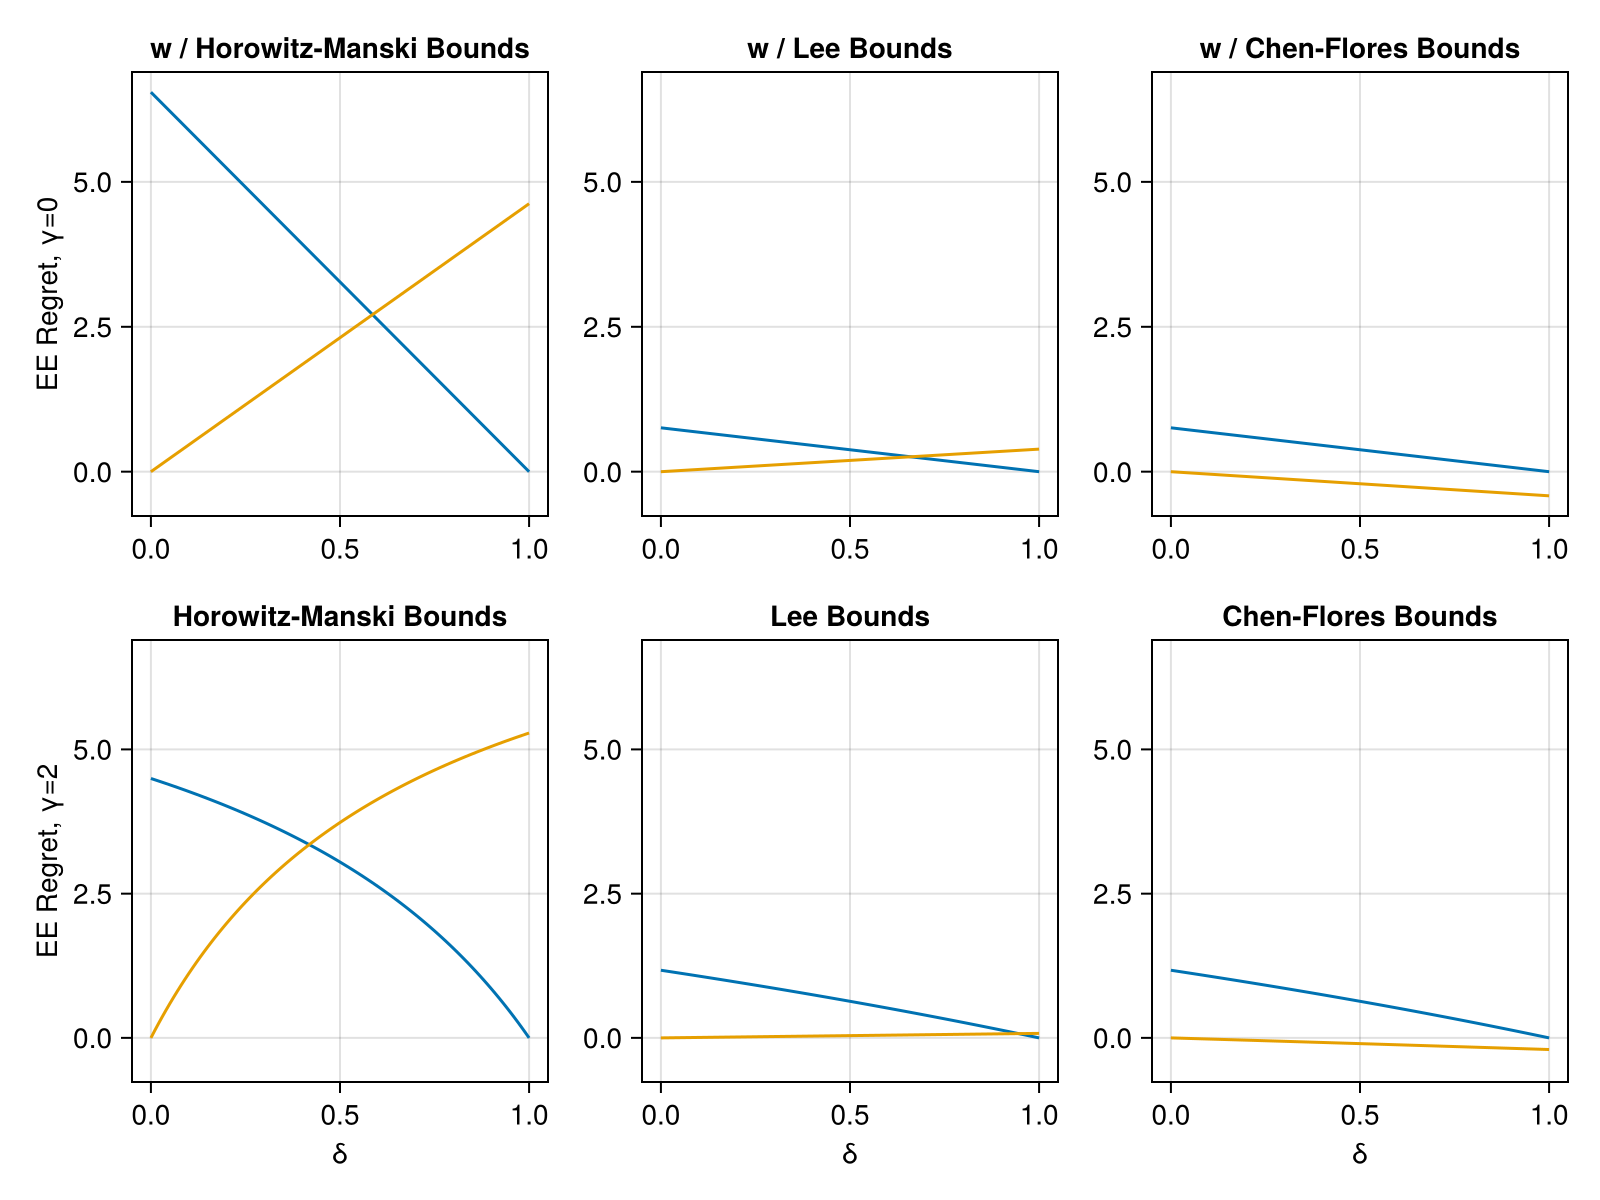

In [13]:
# Initialize figure and grid layout with the updated `size` keyword
fig = Figure(size = (800, 600))
axes = []

# Titles and labels for each subplot
titles = ["w / Horowitz-Manski Bounds", "w / Lee Bounds", "w / Chen-Flores Bounds", "Horowitz-Manski Bounds", "Lee Bounds", "Chen-Flores Bounds"]

ylabels = ["EE Regret, γ=0", "", "", "EE Regret, γ=2", "", ""]
xlabels = ["", "", "", "δ", "δ", "δ"]

# Create axes using a loop referencing the title and labels
for i in 1:2, j in 1:3
    index = (i - 1) * 3 + j
    ax = Axis(fig[i, j], title=titles[index], ylabel=ylabels[index], xlabel=xlabels[index])
    push!(axes, ax)
end

# Plot LHS and RHS values for all 6 plots with loop
for i in 1:6
    lines!(axes[i], z_values, all_rhs_values[i], label="LHS")
    lines!(axes[i], z_values, all_lhs_values[i], label="RHS")
end

# Link y-axes of all plots
linkyaxes!(axes...)

# Display the figure
fig

In [14]:
save("jobcorps_ota_2_and_1.png", fig)

CairoMakie.Screen{IMAGE}
